In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import calendar


In [ ]:
# After cleaning
df = pd.read_csv("https://dnaik2awsbucket.s3.amazonaws.com/Spill_Incidents.csv")
print(df.shape)


(542125, 15)


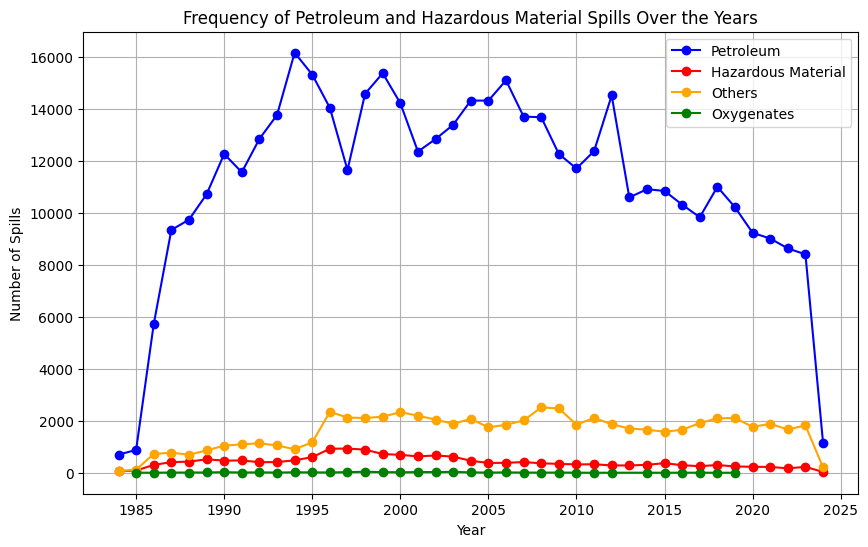

In [ ]:
# Research Question 1: How has the frequency and severity of spills of petroleum and hazardous materials changed over the years, and are there specific patterns (or factors ) associated with a higher incidence of spills?
df['Spill Date'] = pd.to_datetime(df['Spill Date'])

df['Year'] = df['Spill Date'].dt.year

petroleum_spills = df[df['Material Family'] == 'Petroleum']
hazardous_spills = df[df['Material Family'] == 'Hazardous Material']
other_spills = df[df['Material Family'] == 'Other']
oxygenate_spills = df[df['Material Family'] == 'Oxygenates']

petroleum_spills_by_year = petroleum_spills.groupby('Year').size()
hazardous_spills_by_year = hazardous_spills.groupby('Year').size()
other_spills_by_year = other_spills.groupby('Year').size()
oxygenate_spills_by_year = oxygenate_spills.groupby('Year').size()

plt.figure(figsize=(10, 6))
petroleum_spills_by_year.plot(kind='line', marker='o', color='blue', label='Petroleum')
hazardous_spills_by_year.plot(kind='line', marker='o', color='red', label='Hazardous Material')
other_spills_by_year.plot(kind='line', marker='o', color='orange', label='Others')
oxygenate_spills_by_year.plot(kind='line', marker='o', color='green', label='Oxygenates')
plt.title('Frequency of Petroleum and Hazardous Material Spills Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Spills')
plt.legend()
plt.grid(True)
plt.show()

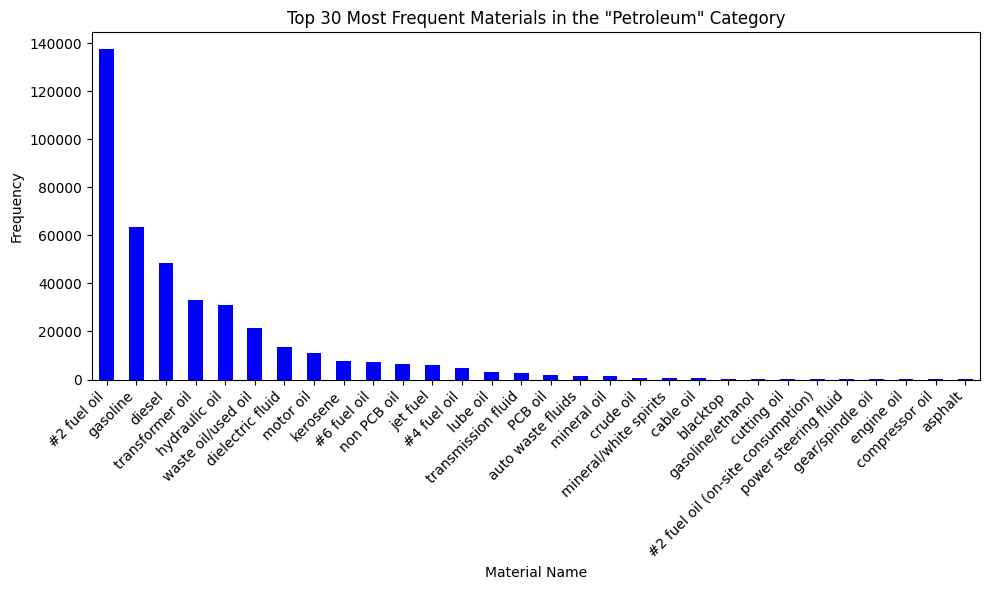

In [ ]:
petroleum_spills = petroleum_spills[~petroleum_spills['Material Name'].str.contains('unknown', na=False)]
petroleum_material_counts = petroleum_spills['Material Name'].value_counts()

petroleum_top_materials = petroleum_material_counts.head(30)

plt.figure(figsize=(10, 6))
petroleum_top_materials.plot(kind='bar', color='blue')
plt.title('Top 30 Most Frequent Materials in the "Petroleum" Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

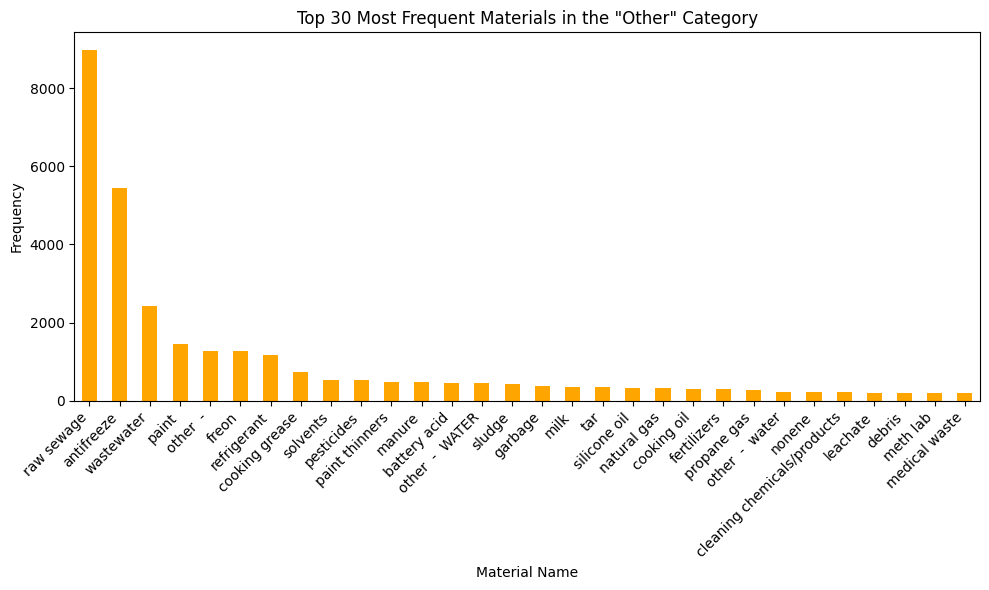

In [ ]:
other_spills = other_spills[~other_spills['Material Name'].str.contains('unknown', na=False)]

other_material_counts = other_spills['Material Name'].value_counts()

top_other_materials = other_material_counts.head(30)

plt.figure(figsize=(10, 6))
top_other_materials.plot(kind='bar', color='orange')
plt.title('Top 30 Most Frequent Materials in the "Other" Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


count       12.000000
mean     40288.166667
std       3762.477951
min      32990.000000
25%      38319.500000
50%      40561.000000
75%      43851.250000
max      44722.000000
Name: count, dtype: float64
Minimum spill incidents took place in  February
Maximum spill incidents took place in  August

Significant sources in  August :
Source
Commercial/Industrial                      12775
Private Dwelling                            8357
Commercial Vehicle                          5960
Institutional, Educational, Gov., Other     3931
Gasoline Station or other PBS Facility      2995
Transformer                                 1977
Passenger Vehicle                           1423
Tank Truck                                   669
Vessel                                       583
Major Facility (MOSF) > 400,000 gal          454
Non Major Facility > 1,100 gal               331
Railroad Car                                 187
Airport/Aircraft                              90
Chemical Bulk Storage Fa

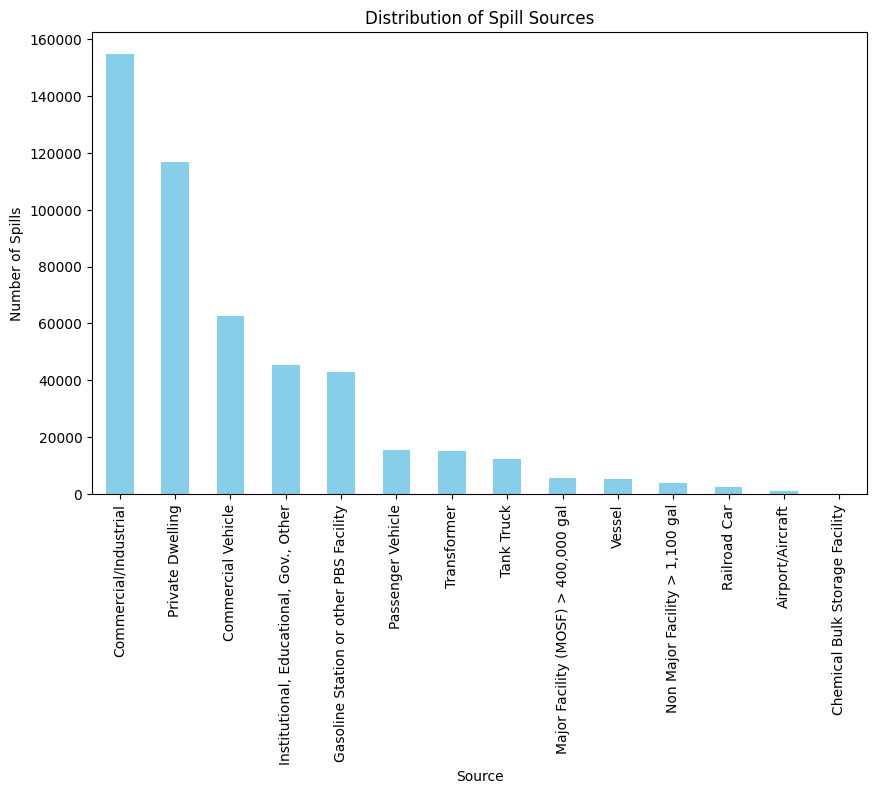

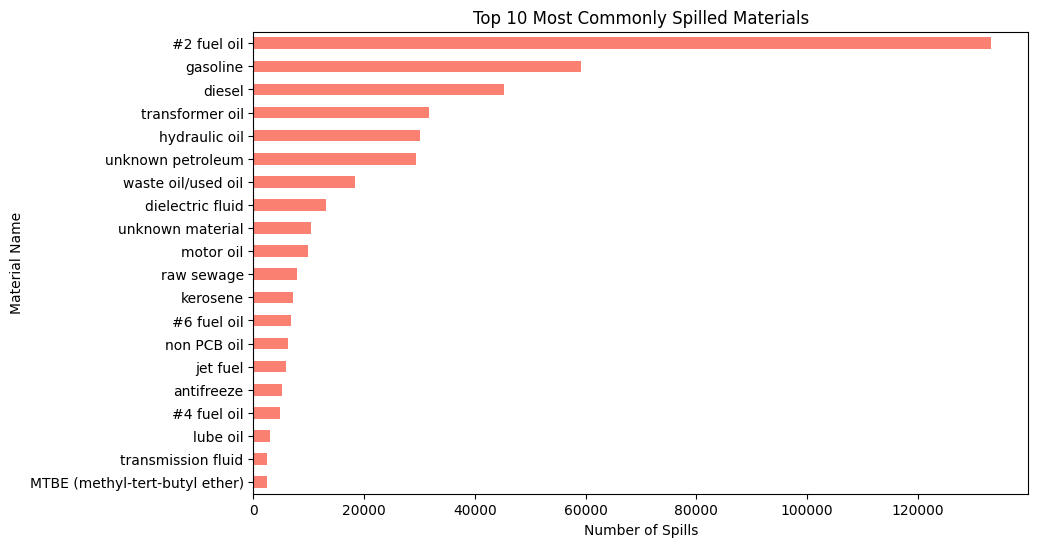

In [ ]:
# Research Question 2: When is the peak time for most industrial spills? Where do the large spills come from? Which types of materials are the most commonly spilled?

# 1. Peak Time for Industrial Spills

df['Spill Date'] = pd.to_datetime(df['Spill Date'])
df['Month'] = df['Spill Date'].dt.month

monthly_counts = df['Month'].value_counts().sort_index()

print(monthly_counts.describe())
monthly_counts = {k: v for k, v in monthly_counts.items() if v is not None}
min_month = min(monthly_counts, key=monthly_counts.get)
max_month = max(monthly_counts, key=monthly_counts.get)
print("Minimum spill incidents took place in ", calendar.month_name[min_month])
print("Maximum spill incidents took place in ", calendar.month_name[max_month])

spills_in_peak_month = df[df['Spill Date'].dt.month == max_month]

spills_in_peak_month = spills_in_peak_month[spills_in_peak_month['Contributing Factor'] != 'Missing Code in Old Data - Must be fixed']
spills_in_peak_month = spills_in_peak_month[~spills_in_peak_month['Contributing Factor'].str.contains('Unknown', na=False)]
spills_in_peak_month = spills_in_peak_month[~spills_in_peak_month['Source'].str.contains('Unknown', na=False)]

significant_sources = spills_in_peak_month['Source'].value_counts()
print("\nSignificant sources in ",calendar.month_name[max_month],":")
print(significant_sources)

significant_factors = spills_in_peak_month['Contributing Factor'].value_counts()
print("Significant contributing factors in ",calendar.month_name[max_month],":")
print(significant_factors)

significant_materials = spills_in_peak_month['Material Name'].value_counts()
print("\nSignificant material names in ",calendar.month_name[max_month],":")
print(significant_materials)


# 2. Origin of Large Spills
df = df[~df['Source'].str.contains('Unknown', na=False)]
plt.figure(figsize=(10, 6))
df['Source'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Spill Sources')
plt.xlabel('Source')
plt.ylabel('Number of Spills')
plt.show()

# 3. Commonly Spilled Materials
df = df[~df['Material Name'].str.contains('Unknown', na=False)]
plt.figure(figsize=(10, 6))
df['Material Name'].value_counts().head(20).plot(kind='barh', color='salmon')
plt.title('Top 10 Most Commonly Spilled Materials')
plt.xlabel('Number of Spills')
plt.ylabel('Material Name')
plt.gca().invert_yaxis()
plt.show()


<Axes: title={'center': 'Sources of spills and their causes'}, xlabel='Contributing Factor', ylabel='Source'>

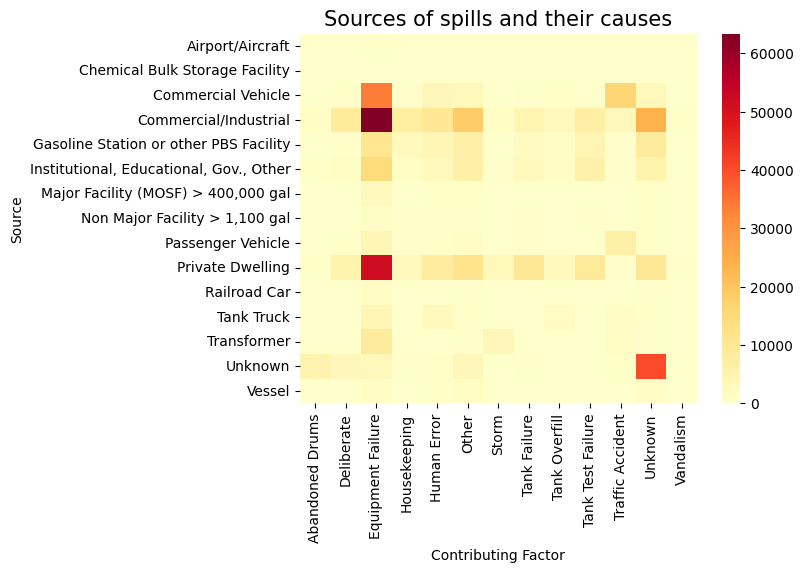

In [ ]:
# Research Question 3: What are the primary contributing factors? Is there any correlation between these factors and sources of origin?
sourcesVScauses_df = pd.crosstab(df['Source'], df['Contributing Factor'],margins=True)
# df = df[df['Source']!='Missing Code in Old Data - Must be fixed']
sourcesVScauses_df = sourcesVScauses_df.drop(['Missing Code in Old Data - Must be fixed'], axis=1).copy()
sourcesVScauses_df
sourcesVScauses_df = sourcesVScauses_df.iloc[0:15,0:13].copy()
plt.title('Sources of spills and their causes', fontsize=15)
sns.heatmap(sourcesVScauses_df, cmap='YlOrRd')

In [ ]:
# Research Question 6: What is the average time between spill occurrence and reporting, and how promptly are spills typically resolved?
df['Spill Date'] = pd.to_datetime(df['Spill Date'])
df['Received Date'] = pd.to_datetime(df['Received Date'])
df['Close Date'] = pd.to_datetime(df['Close Date'])
df['Reporting Time'] = df['Received Date'] - df['Spill Date']
df['Resolution Time'] = df['Close Date'] - df['Spill Date']
avg_reporting_time = df['Reporting Time'].mean()
avg_resolution_time = df['Resolution Time'].mean()

print('Statistics for Reporting Time\n', df['Reporting Time'].describe())
print('Statistics for Resolution Time\n', df['Resolution Time'].describe())

df[['Spill Number','Spill Date', 'Received Date', 'Close Date', 'Reporting Time', 'Resolution Time']].head()

Statistics for Reporting Time
 count                         541689
mean       3 days 16:47:40.333512402
std      343 days 01:53:16.792629560
min            -36525 days +00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%                  0 days 00:00:00
max              12058 days 00:00:00
Name: Reporting Time, dtype: object
Statistics for Resolution Time
 count                          531585
mean      404 days 10:19:53.844070108
std      1051 days 15:54:50.841501376
min              -6056 days +00:00:00
25%                   2 days 00:00:00
50%                  42 days 00:00:00
75%                 246 days 00:00:00
max               13709 days 00:00:00
Name: Resolution Time, dtype: object


Spill Number Spill Date Received Date Close Date Reporting Time  \
0       8401641 1984-01-01    1984-01-01 1989-01-03         0 days   
1       8412000 1984-01-01    1984-01-01 2004-12-18         0 days   
2       8301968 1984-01-01    1983-12-31 1988-07-07        -1 days   
3       8400577 1984-01-01    1984-05-30 1989-03-10       150 days   
4       8400577 1984-01-01    1984-05-30 1989-03-10       150 days   

  Resolution Time  
0       1829 days  
1       7657 days  
2       1649 days  
3       1895 days  
4       1895 days

In [ ]:

df = df[(df['Received Date'] >= df['Spill Date']) & (df['Close Date'] >= df['Spill Date'])]

df = df.copy()
print(df.shape)
df.head()

(529323, 17)


Spill Date  Spill Number            Street 1       Locality      County  \
0 1984-01-01       8401641    TOWN WELL SUPPLY    CHESTERTOWN      Warren   
1 1984-01-01       8412000                ARCO  SPRING VALLEY    Rockland   
3 1984-01-01       8400577              RT. 40      GRANVILLE  Washington   
4 1984-01-01       8400577              RT. 40      GRANVILLE  Washington   
5 1984-01-02       8402683  22 MEADOWOOD DRIVE       PERINTON      Monroe   

  Received Date Contributing Factor          Waterbody Close Date   Source  \
0    1984-01-01             Unknown                NaN 1989-01-03  Unknown   
1    1984-01-01             Unknown                NaN 2004-12-18  Unknown   
3    1984-05-30             Unknown                NaN 1989-03-10  Unknown   
4    1984-05-30             Unknown                NaN 1989-03-10  Unknown   
5    1985-01-04             Unknown  IRONDEQUOIT CREEK 1986-06-01  Unknown   

       Material Name Material Family  Quantity    Units  Recovered  \
0           gasoline       Petroleum       0.0  Gallons        0.0   
1  unknown petroleum       Petroleum       0.0      NaN        0.0   
3        #2 fuel oil       Petroleum       0.0  Gallons        0.0   
4           gasoline       Petroleum       0.0  Gallons        0.0   
5        #2 fuel oil       Petroleum      10.0  Gallons        0.0   

  Reporting Time Resolution Time  
0         0 days       1829 days  
1         0 days       7657 days  
3       150 days       1895 days  
4       150 days       1895 days  
5       368 days        881 days

In [ ]:
print('Statistics for Reporting Time\n', df['Reporting Time'].describe())
print('Statistics for Resolution Time\n', df['Resolution Time'].describe())

df[['Spill Number','Spill Date', 'Received Date', 'Close Date', 'Reporting Time', 'Resolution Time']].head()

Statistics for Reporting Time
 count                         529323
mean       7 days 08:21:28.353613956
std      108 days 15:58:00.060249428
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%                  0 days 00:00:00
max              10669 days 00:00:00
Name: Reporting Time, dtype: object
Statistics for Resolution Time
 count                          529323
mean      405 days 01:29:54.011595960
std      1048 days 00:49:41.383459440
min                   0 days 00:00:00
25%                   2 days 00:00:00
50%                  42 days 00:00:00
75%                 247 days 00:00:00
max               13709 days 00:00:00
Name: Resolution Time, dtype: object


Spill Number Spill Date Received Date Close Date Reporting Time  \
0       8401641 1984-01-01    1984-01-01 1989-01-03         0 days   
1       8412000 1984-01-01    1984-01-01 2004-12-18         0 days   
3       8400577 1984-01-01    1984-05-30 1989-03-10       150 days   
4       8400577 1984-01-01    1984-05-30 1989-03-10       150 days   
5       8402683 1984-01-02    1985-01-04 1986-06-01       368 days   

  Resolution Time  
0       1829 days  
1       7657 days  
3       1895 days  
4       1895 days  
5        881 days

In [ ]:
df['Spill Date'] = pd.to_datetime(df['Spill Date'])
df['Reporting Time'] = pd.to_timedelta(df['Reporting Time']).dt.days
df['Resolution Time'] = pd.to_timedelta(df['Resolution Time']).dt.days

df['Spill Year'] = df['Spill Date'].dt.year


In [ ]:
fig = px.line(df, x='Spill Year', y='Reporting Time',
              labels={'value': 'Time (days)', 'Spill Year': 'Spill Year'},
              color_discrete_sequence=['salmon'],
              title='Reporting Time over years')

fig.show()

In [ ]:
fig = px.line(df, x='Spill Year', y='Resolution Time',
              labels={'value': 'Time (days)', 'Spill Year': 'Spill Year'},
              title='Resolution Time over years')

fig.show()